In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
dataframe = pd.read_csv('drive/MyDrive/region_manager_clustered-with-name-description-clust.csv')

In [ ]:
import re
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup as bs
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def preprocess(sentence):
    soup = bs(sentence, features="html.parser")
    sentence = soup.get_text()
    soup = bs(sentence, features="html.parser")
    sentence = soup.get_text()

    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if not w in stopwords.words('russian')]

    return " ".join(filtered_words)

In [ ]:
dataframe['description'] = dataframe['description'].apply(lambda x: preprocess(x))

<ipython-input-60-de2d3243c396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economist_cleaned['description'] = economist_cleaned['description'].apply(lambda x: preprocess(x))


In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [ ]:
def lemmatize(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

dataframe['description'] = dataframe['description'].apply(lambda x: lemmatize(x))

<ipython-input-61-984365f60466>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economist_cleaned['description'] = economist_cleaned['description'].apply(lambda x: lemmatize(x))


### **Cluster**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceCl

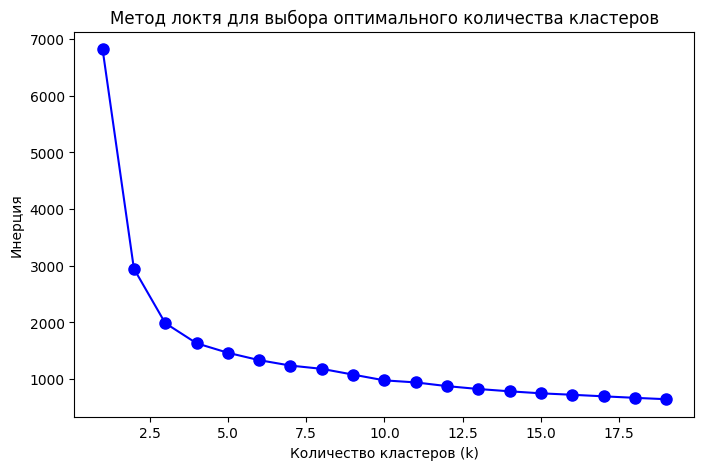

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

model.to(device)

def tokenize_function(text):
    return tokenizer(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=512, return_tensors="pt")['input_ids']

dataframe['token'] = dataframe['description'].apply(lambda x: tokenize_function(x))

input_ids_tensor = torch.cat(list(dataframe['token'].values))
batch_size = 32

input_ids_batches = torch.split(input_ids_tensor, batch_size)

model.eval()

all_embeddings = []
with torch.no_grad():
    for batch in tqdm(input_ids_batches):
        batch = batch.to(device)
        outputs = model(batch)
        sentence_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(sentence_embeddings.cpu())

sentence_embeddings_tensor = torch.cat(all_embeddings)

sentence_embeddings_np = sentence_embeddings_tensor.numpy()

inertia = []
k_values = range(1, 20)

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sentence_embeddings_np)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-', markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-65-baaf2eedd88d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economist_cleaned['cluster'] = kmeans.labels_


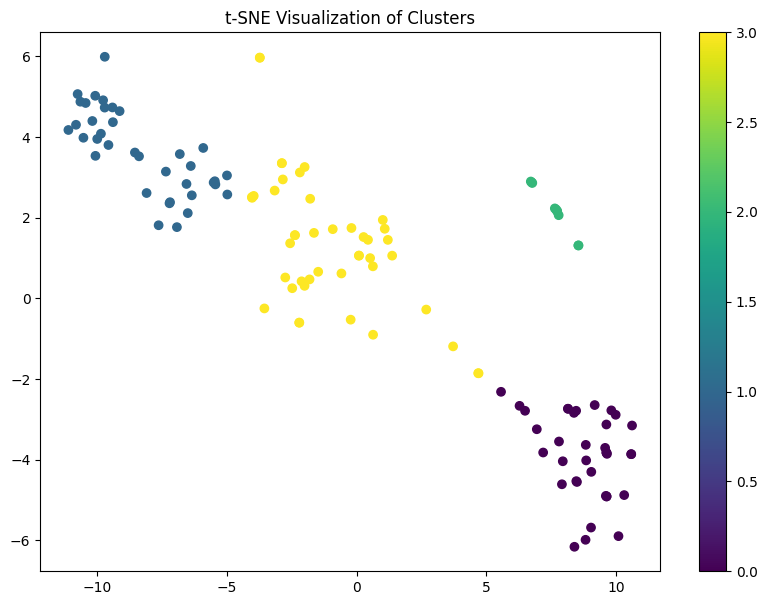

In [ ]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(sentence_embeddings_np)

dataframe['cluster'] = kmeans.labels_

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sentence_embeddings_np)

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dataframe['cluster'], cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clusters')
plt.show()

dataframe.to_csv('econimist-clus.csv', index=False)

## **end Cluster **

In [ ]:
import pandas as pd

In [ ]:
reg_manager = pd.read_csv('drive/MyDrive/region_manager_clustered-with-name-description-clust.csv')
economist = pd.read_csv('econimist-clus.csv')

In [ ]:
economist['word_count'] = economist['description'].apply(lambda x: len(str(x).split()))

In [ ]:
reg = reg_manager[reg_manager['cluster'] == 1]

In [ ]:
econ = economist[economist['cluster'] == 3]

In [ ]:
reg

,Unnamed: 0,name,description,cluster
0,0,Региональный менеджер по продажам,обязанность продвижение продукция компания пои...,1
1,1,Региональный менеджер,обязанность взаимодействие текущий клиент увел...,1
7,7,Региональный менеджер по оптовым продажам стро...,обязанность оптовый продажа строительный матер...,1
9,9,Региональный менеджер по продажам,обязанность развитие вверить регион систематиз...,1
14,14,Региональный менеджер по работе с ключевыми кл...,обязанность работа дистрибьютор территория рк ...,1
...,...,...,...,...
3790,3790,Региональный менеджер по продажам,обязанность оптовый продажа цемент активный пр...,1
3792,3792,Региональный менеджер по продажам,обязанность приём обработка входящий звонок за...,1
3794,3794,Региональный менеджер по не табачному ассортим...,обязанность участие разработка реализация стра...,1
3799,3799,Менеджер по работе с регионами,обязанность подбор региональный представитель ...,1


In [ ]:
columns_in_reg = reg.columns

In [ ]:
economist_filtered = econ[columns_in_reg.intersection(econ.columns)]

In [ ]:
reg.drop('Unnamed: 0', axis=1, inplace=True)

<ipython-input-20-ba1becf854d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg.drop('Unnamed: 0', axis=1, inplace=True)


In [ ]:
economist_filtered = economist_filtered[:921]

In [ ]:
combined_df = pd.concat([reg, economist_filtered], axis=0, ignore_index=True)

In [ ]:
combined_df

,name,description,cluster,word_count
0,Региональный менеджер по продажам,обязанность продвижение продукция компания пои...,1,45
1,Региональный менеджер,обязанность взаимодействие текущий клиент увел...,1,30
2,Региональный менеджер по оптовым продажам стро...,обязанность оптовый продажа строительный матер...,1,23
3,Региональный менеджер по продажам,обязанность развитие вверить регион систематиз...,1,24
4,Региональный менеджер по работе с ключевыми кл...,обязанность работа дистрибьютор территория рк ...,1,30
...,...,...,...,...
1837,Экономист,обязанности формирование экономической политик...,3,34
1838,Экономист-финансист,обязанности анализ оптимизация затрат организа...,3,37
1839,Менеджер-экономист,обязанности ведение аналитики excel работа дог...,3,19
1840,Бухгалтер-экономист,обязанности ведения учета поступающих денежных...,3,62


In [ ]:
economist_filtered['word_count'].mean()

47.1628664495114

In [ ]:
combined_df = pd.concat([reg, economist_filtered], axis=0, ignore_index=True)

In [ ]:
def lemmatize(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

combined_df['description'] = combined_df['description'].apply(lambda x: lemmatize(x))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = combined_df['description']
y = combined_df['cluster']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
print(f"Train size: {X_train.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"test size: {X_test.shape[0]}")

Train size: 1289
Val size: 276
test size: 277


In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def tokenize_and_format(sentences):
    max_length = 512
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens = True,
            max_length = max_length,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

X_tokenized, attention_masks = tokenize_and_format(X)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


NameError: name 'X' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(reg['description'], reg['cluster'], test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels.tolist())
val_dataset = Dataset(val_encodings, val_labels.tolist())

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=len(set(reg['cluster'])))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.003429
2,No log,0.000190


ValueError: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.

In [ ]:
trainer.evaluate()